In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.spatial.transform import Rotation as R 
import pickle 
import os 
import glob 
from mpl_toolkits.mplot3d import Axes3D 
import random 
import heapq

In [4]:
hole_classes = ['HOLE1','HOLE2','HOLE3','TOP'] 
peg_classes = ['PIN1','PIN2','PIN3','BASE'] 
peg_hole_classes = [] 
for hole_class in hole_classes: 
    for peg_class in peg_classes: 
        peg_hole_classes.append(f'{hole_class}-{peg_class}') 

In [5]:
def classify_hole_point(contact_pos_hole_frame, contact_geom1): 
    if contact_pos_hole_frame[2] > -0.001:  
        return 'TOP' 
    else: # FIXME: this is a crude way of checking which element is in contact using cylinders 
        x = contact_pos_hole_frame[0] 
        y = contact_pos_hole_frame[1] 
        if (x-0)**2 + (y - -10)**2 < 8:  
            return 'HOLE1' 
        elif (x - -6)**2 + (y - 3.5)**2 < 10: 
            return 'HOLE2' 
        elif (x - 6)**2 + (y - 3.5)**2 < 8: 
            return 'HOLE3'
        else:
            return []  

def classify_peg_point(contact_geom2): 
    if contact_geom2 == 22: 
        return 'BASE' 
    elif contact_geom2 == 23: 
        return 'PIN1' 
    elif contact_geom2 == 24: 
        return 'PIN2' 
    elif contact_geom2 == 25: 
        return 'PIN3'
    else: 
        return [] 

In [6]:
dir_results = "/media/rp/Elements/abhay_ws/mujoco_contact_graph_generation/results/plug_3_pin_data_v2" 
dir_pkl = dir_results + "/pkl" 
pkl_files = sorted(glob.glob(os.path.join(dir_pkl, "*.pkl")), key=os.path.getmtime)

dir_save = dir_pkl.removesuffix("pkl") + "processed_data"
if not os.path.exists(dir_save): 
    os.makedirs(dir_save)

# list of all contact state history 
N_timesteps = 500 
N_trials = 100000 # len(pkl_files) 
pkl_files = pkl_files[:N_trials] 
contact_matrix_hist_all = np.zeros((len(hole_classes), len(peg_classes), N_timesteps, N_trials), dtype=bool) 
N_single_contact = len(hole_classes)*len(peg_classes) 
mujoco_state_labels = ['time','X','Y','Z','QX','QY','QZ','QW','X_dot','Y_dot','Z_dot','A_dot','B_dot','C_dot','FX','FY','FZ','TX','TY','TZ','x','y','z','qx','qy','qz','qw'] 
N_state_mujoco = len(mujoco_state_labels) 
N_states = N_state_mujoco + N_single_contact
state_hist_all = np.zeros((N_states, N_timesteps, N_trials)) 
contact_state_hist_all = np.zeros((N_timesteps, N_trials, N_single_contact), dtype=bool) 
quasi_static_hist_all = np.zeros((N_timesteps, N_trials), dtype=bool) 
quasi_static_thresh = 0.001 # 1 mm/s 
flag_quasi_static_constraint = False 

for i, pkl_file in enumerate(pkl_files): 

    # Read the pickle file
    with open(pkl_file, 'rb') as f:
        data = pickle.load(f)

    # unpack data 
    state_hist = data['state_hist'] 
    contact_num = data['contact_num'] 
    contact_geom1 = data['contact_geom1'] 
    contact_geom2 = data['contact_geom2'] 
    # contact_dist = data['contact_dist'] 
    contact_pos = data['contact_pos'] 
    # contact_frame = data['contact_frame'] 
    # ctrl_hist = data['ctrl_hist'] 
    sensor_hist = data['sensor_hist']   

    # initialize data structure for contact state history 
    contact_state_hist = np.zeros((len(hole_classes), len(peg_classes), len(state_hist)), dtype=bool)

    for j, contact_pos_j in enumerate(contact_pos): # iterate through each time step 

        if flag_quasi_static_constraint: 
            # check if the contact is quasi-static 
            if np.max(np.abs(state_hist[j,8:11])) < quasi_static_thresh: 
                quasi_static_hist_all[j,i] = True 
            else:  
                quasi_static_hist_all[j,i] = False 
                continue 

        if len(contact_pos_j) > 0: # if there is contact 
            peg_pos = state_hist[j, 1:4] * 1e3 # convert from m to mm 
            peg_quat = state_hist[j, 4:8] 
            peg_R = R.from_quat(peg_quat,scalar_first=True).as_matrix() 
            for k, contact_pos_hole_frame in enumerate(contact_pos_j): # iterate through each contact at current time step 
                contact_pos_hole_frame *= 1e3 # convert from m to mm 
                # contact_pos_peg_frame = (peg_R.transpose() @ (contact_pos_hole_frame - peg_pos).reshape(3,1)).reshape(3)  
                point_hole_class = classify_hole_point(contact_pos_hole_frame, contact_geom1[j][k])  
                point_peg_class = classify_peg_point(contact_geom2[j][k]) 

                for ii, hole_class in enumerate(hole_classes): 
                    for jj, peg_class in enumerate(peg_classes): 
                        if (hole_class in point_hole_class) and (peg_class in point_peg_class): 
                            contact_state_hist[ii,jj,j] = True 

        contact_state_hist_all[j,i] = contact_state_hist[:,:,j].flatten().astype(int) 
        state_hist_all[:N_state_mujoco,j,i] = np.hstack((state_hist[j,:], sensor_hist[j,:])) 
        state_hist_all[N_state_mujoco:,j,i] = contact_state_hist[:,:,j].flatten().astype(int) 

    # save contact state history to list 
    contact_matrix_hist_all[:,:,:,i] = contact_state_hist 

state_hist_all_flat = state_hist_all.reshape(N_states, N_timesteps*N_trials).transpose() 
df_state = pd.DataFrame(state_hist_all_flat, columns=mujoco_state_labels+peg_hole_classes)   

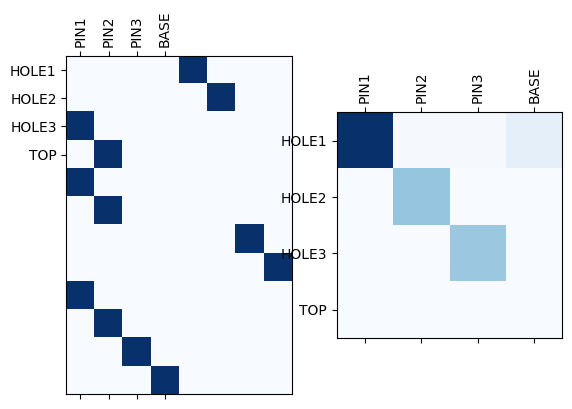

In [ ]:
# plot frequencies of contact element pairs 

contact_state_freq = np.sum(np.sum(contact_matrix_hist_all, axis=3), axis=2) 

contact_state_paper = np.array([[0,0,0,0,1,0,0,0],
                                  [0,0,0,0,0,1,0,0],
                                  [1,0,0,0,0,0,0,0],
                                  [0,1,0,0,0,0,0,0],
                                  [1,0,0,0,0,0,0,0],
                                  [0,1,0,0,0,0,0,0],
                                  [0,0,0,0,0,0,1,0],
                                  [0,0,0,0,0,0,0,1],
                                  [1,0,0,0,0,0,0,0],
                                  [0,1,0,0,0,0,0,0],
                                  [0,0,1,0,0,0,0,0],
                                  [0,0,0,1,0,0,0,0]]) 

fig, axs = plt.subplots(1,2)

# label axes with peg_classes and hole_classes 
axs[0].set_xticks(np.arange(len(peg_classes)))
axs[0].set_yticks(np.arange(len(hole_classes)))

axs[0].matshow(contact_state_paper, cmap=plt.cm.Blues)
for i in range(contact_state_paper.shape[0]):
    for j in range(contact_state_paper.shape[1]):
        c = contact_state_paper[i,j] 

axs[0].set_xticks([0,1,2,3], peg_classes, rotation=90)
axs[0].set_yticks([0,1,2,3], hole_classes, rotation=0 ) 

axs[1].matshow(contact_state_freq, cmap=plt.cm.Blues)
for i in range(contact_state_freq.shape[0]):
    for j in range(contact_state_freq.shape[1]):
        c = contact_state_freq[i,j]

axs[1].set_xticks([0,1,2,3], peg_classes, rotation=90)
axs[1].set_yticks([0,1,2,3], hole_classes, rotation=0 ) 
        

15 unique contact state types found.


Text(0, 0.5, 'Number of unique contact state types found')

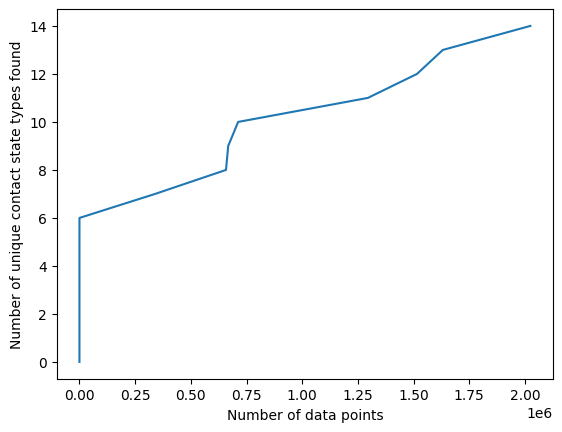

In [ ]:
# identify contact state types and label each contact state in history 

# RUNTIME: 
# 1.5m for 100 trials of 500 timesteps 
# 40m for 1000 trials of 500 timesteps
# 360m for 10000 trials of 500 timesteps 

contact_types_matrix_list = [] 
contact_types_matrix_freq = [] 
contact_type_idx_discover_list = [] 
contact_state_type_hist_all = np.zeros((N_timesteps, N_trials), dtype=int) - 1 
no_contact_matrix = np.zeros((len(hole_classes), len(peg_classes)), dtype=bool) 

for i in range(N_timesteps):    
    for j in range(N_trials): 

        contact_state_ij = contact_matrix_hist_all[:,:,i,j] 

        # label contact state type 
        for k, contact_type_k in enumerate(contact_types_matrix_list): 
            if np.array_equal(contact_state_ij, contact_type_k): 
                contact_state_type_hist_all[i,j] = k # label contact state type 
                contact_types_matrix_freq[k] += 1 
                # contact_type_idx_discover_list.append(i*N_trials + j) 
                break # note: search could be optimized by reordering the list based on frequency of occurence 
        
        # if no match found, add new contact state type 
        if contact_state_type_hist_all[i,j] == -1 and not np.array_equal(contact_state_ij, no_contact_matrix): 
            contact_types_matrix_list.append(contact_state_ij) # add new contact state type to list 
            k_new = len(contact_types_matrix_list) - 1
            contact_state_type_hist_all[i,j] = k_new # new label for contact state type 
            contact_types_matrix_freq.append(1) # create new entry in frequency list and assign value of 1 
            contact_type_idx_discover_list.append(i*N_trials + j) 

        df_state.loc[i*N_trials + j, 'contact_type'] = contact_state_type_hist_all[i,j] 

N_contact_types = len(contact_types_matrix_list) 
print(f"{N_contact_types} unique contact state types found.") 

plt.figure() 
plt.plot(contact_type_idx_discover_list, np.arange(len(contact_type_idx_discover_list))) 
plt.xlabel("Number of data points") 
plt.ylabel("Number of unique contact state types found") 

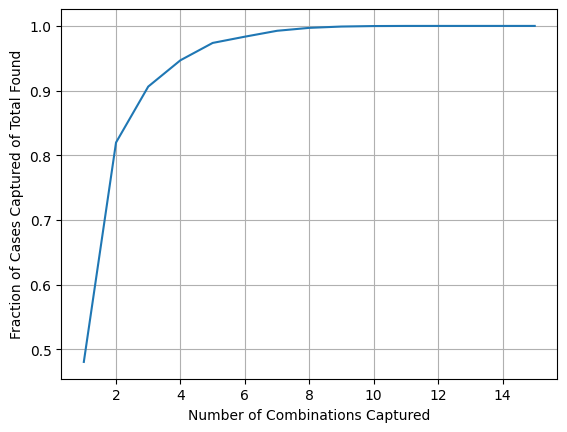

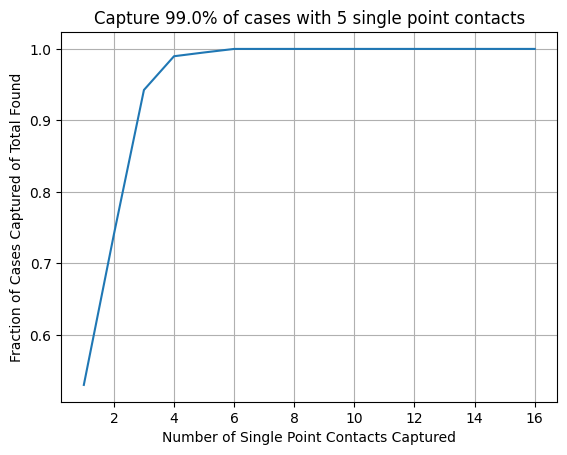

In [ ]:
# plot of percent of cases captured by top N contact state types 
frac_cases_captured = np.zeros(N_contact_types)  
frac_combinations_captured = np.zeros(N_contact_types) 
for N in range(N_contact_types): 
    N_contact_types_top = N + 1 
    top_n = heapq.nlargest(N_contact_types_top, enumerate(contact_types_matrix_freq), key=lambda x: x[1])
    top_values = [value for index, value in top_n]
    top_indices_type = [index for index, value in top_n]
    frac_cases_captured[N] = np.sum(top_values) / np.sum(contact_types_matrix_freq) 

# plot of contact state type frequency  
plt.figure()
plt.plot((np.arange(N_contact_types)+1), frac_cases_captured) 
plt.xlabel('Number of Combinations Captured') 
plt.ylabel('Fraction of Cases Captured of Total Found') 
plt.grid(True)

# plot of percent of cases captured by top N contact state elements  
frac_cases_captured_single_contact = np.zeros(N_single_contact)  
frac_combinations_captured = np.zeros(N_single_contact) 
for N in range(N_single_contact): 
    N_contact_states_top = N + 1 
    top_n = heapq.nlargest(N_contact_states_top, enumerate(contact_state_freq.flatten()), key=lambda x: x[1])
    top_values = [value for index, value in top_n]
    top_indices_state = [index for index, value in top_n]
    frac_cases_captured_single_contact[N] = np.sum(top_values) / np.sum(contact_state_freq.flatten()) 

thresh_capture_single_contact = .99
N_single_contact_capture = np.argmax(frac_cases_captured_single_contact > thresh_capture_single_contact) + 1 

# plot of contact state type frequency  
plt.figure()
plt.plot((np.arange(N_single_contact)+1), frac_cases_captured_single_contact) 
plt.xlabel('Number of Single Point Contacts Captured') 
plt.ylabel('Fraction of Cases Captured of Total Found') 
plt.title(f"Capture {thresh_capture_single_contact*100}% of cases with {N_single_contact_capture} single point contacts") 
plt.grid(True)

Top N values: [1029448, 726787, 185274, 87190, 57363, 20729, 19508, 9703, 4369, 1618, 396, 22, 9, 1, 1]
Indices of top N values: [1, 4, 7, 2, 3, 12, 13, 0, 5, 6, 10, 8, 9, 11, 14]


Text(0.5, 1.0, 'Top N = 15 Contact State Type Frequency \n100.00% of cases captured by 100.00% of combinations')

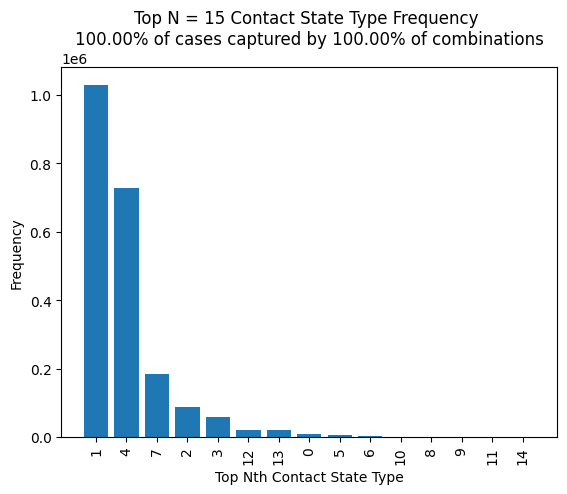

In [ ]:
# find top N values and indices 

N_contact_types_top_freq = np.min([N_contact_types, 100])      
top_n = heapq.nlargest(N_contact_types_top_freq, enumerate(contact_types_matrix_freq), key=lambda x: x[1])
top_values = [value for index, value in top_n]
top_indices_type = [index for index, value in top_n] 
percent_cases_captured = np.sum(top_values) / np.sum(contact_types_matrix_freq) * 100 
percent_combinations_captured = N_contact_types_top_freq / N_contact_types * 100 



print("Top N values:", top_values)
print("Indices of top N values:", top_indices_type) 

# plot histogram of top N values 
plt.figure() 
plt.bar(np.arange(N_contact_types_top_freq), top_values) 
plt.xticks(ticks=range(N_contact_types_top_freq), labels=top_indices_type)
plt.xticks(rotation=90)  # Rotate labels by 90 degrees
plt.xlabel("Top Nth Contact State Type")  
plt.ylabel("Frequency") 
plt.title(f"Top N = {N_contact_types_top_freq} Contact State Type Frequency \n{percent_cases_captured:.2f}% of cases captured by {percent_combinations_captured:.2f}% of combinations")  

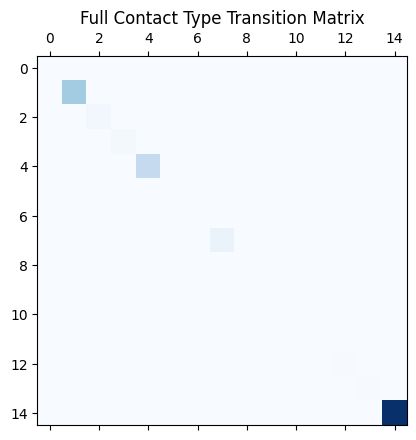

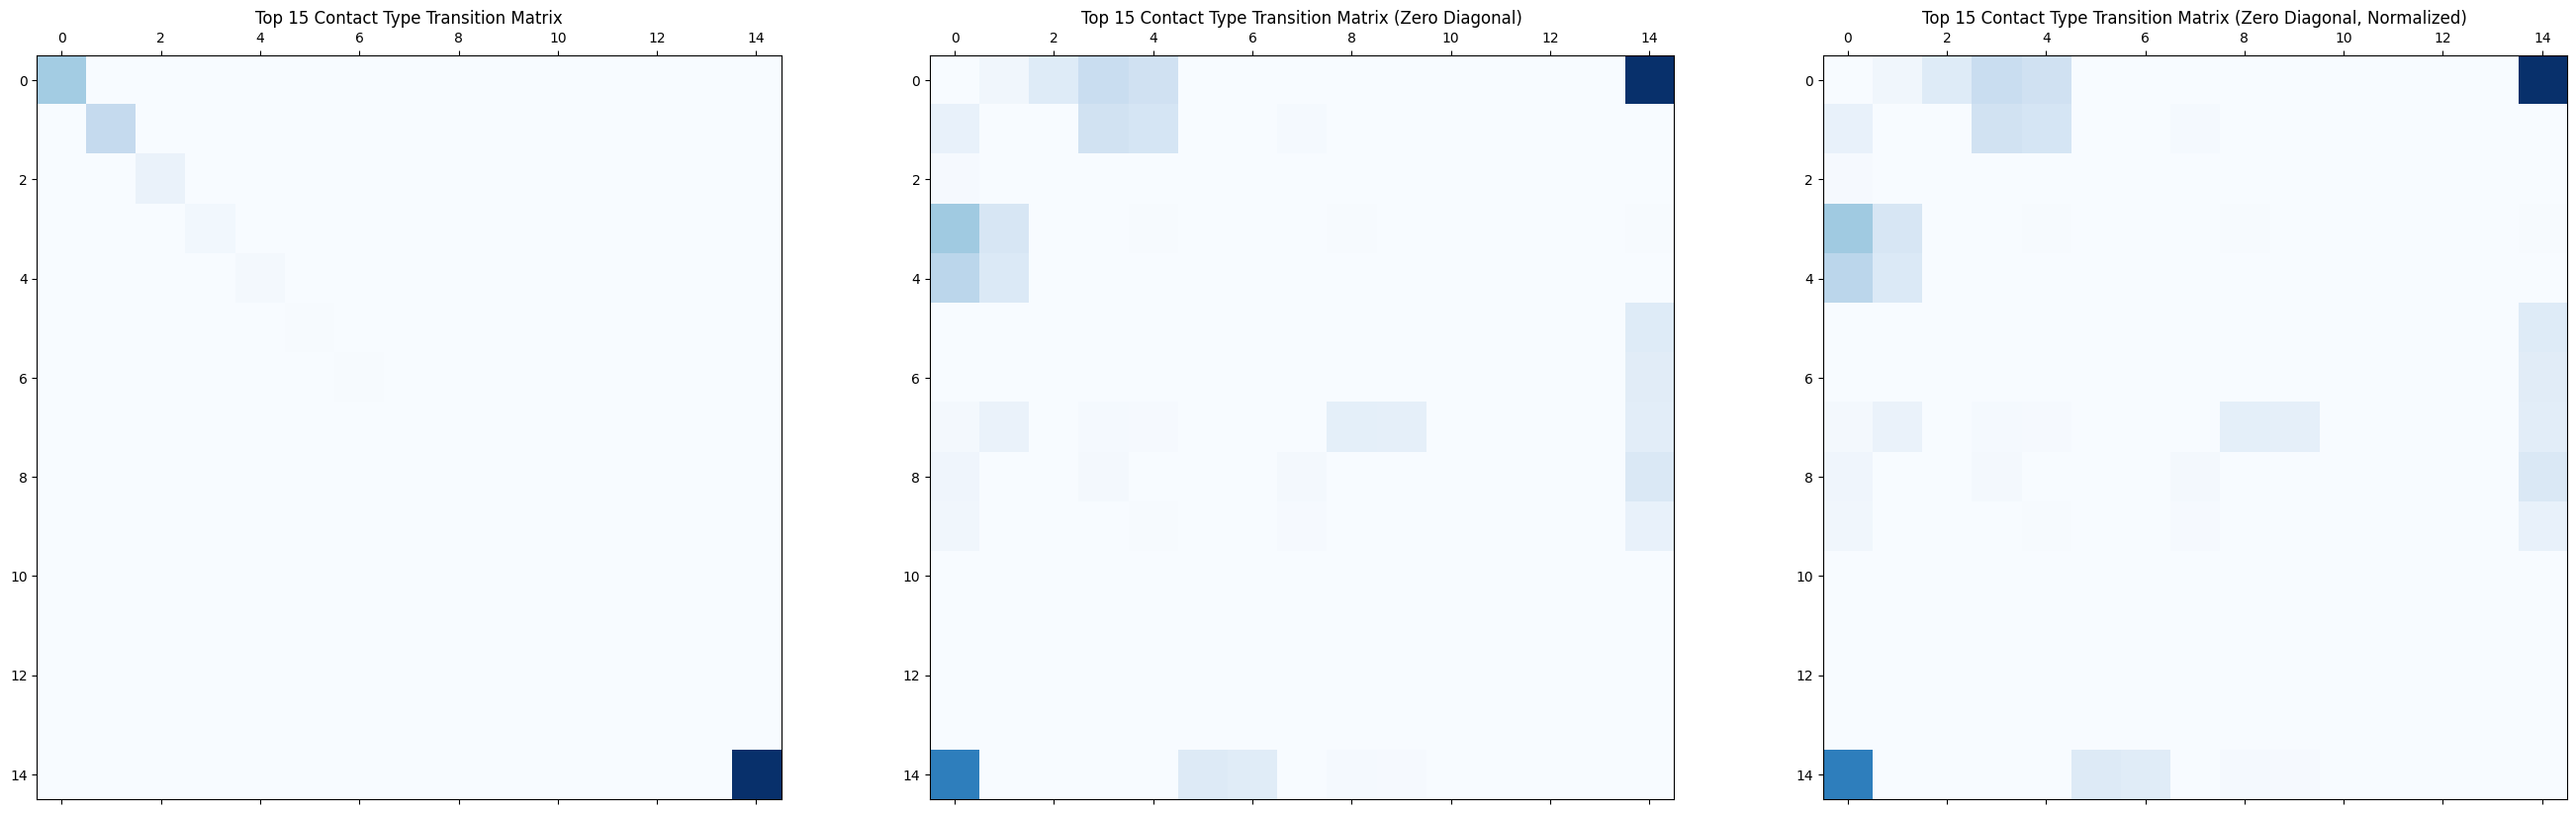

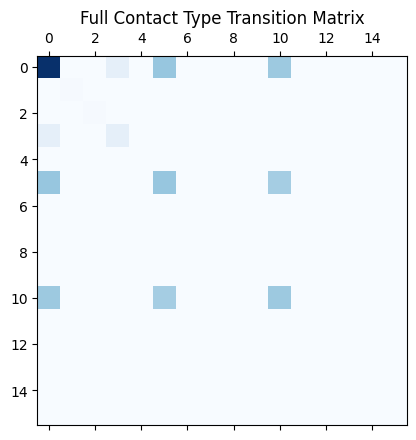

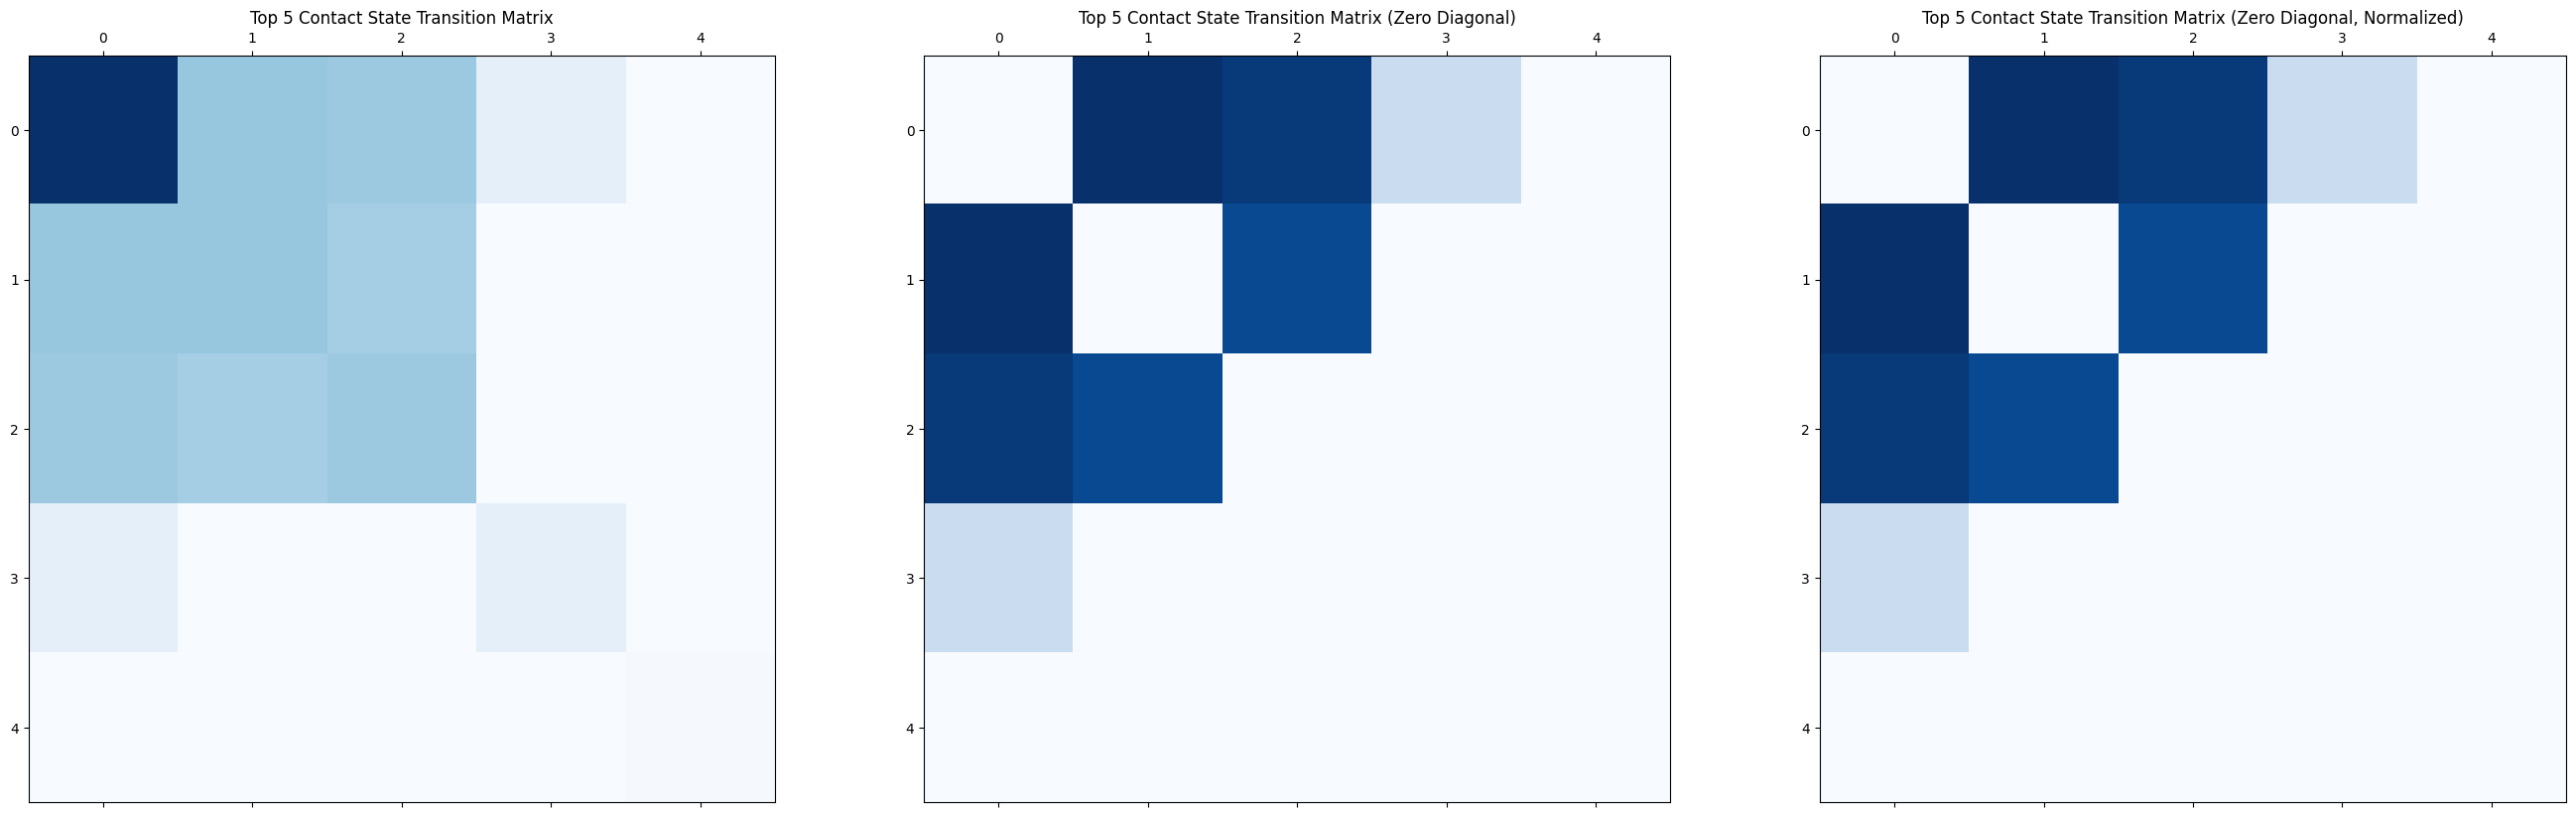

In [ ]:
# identify all unique contact state type transitions and state transitions 

contact_type_transition_matrix = np.zeros((N_contact_types, N_contact_types), dtype=int) 
contact_state_transition_matrix = np.zeros((N_single_contact, N_single_contact), dtype=int) 
for i in range(N_timesteps-1): 
    for j in range(N_trials): 
        contact_state_type_i = contact_state_type_hist_all[i,j] 
        contact_state_type_ip1 = contact_state_type_hist_all[i+1,j] 
        contact_type_transition_matrix[contact_state_type_i, contact_state_type_ip1] += 1 

        contact_state_i = contact_state_hist_all[i,j] 
        contact_state_ip1 = contact_state_hist_all[i+1,j] 
        contact_state_transition_matrix += np.outer(contact_state_i, contact_state_ip1) 

## plot state type transition matrix 
# plot state type transition matrix 
fig, axs = plt.subplots()
axs.matshow(contact_type_transition_matrix, cmap=plt.cm.Blues)
axs.set_title("Full Contact Type Transition Matrix")
for i in range(contact_type_transition_matrix.shape[0]):
    for j in range(contact_type_transition_matrix.shape[1]):
        c = contact_type_transition_matrix[i,j] 

# only plot top N transitions 
contact_type_transition_matrix_top_N = np.zeros((N_contact_types_top_freq, N_contact_types_top_freq), dtype=int)   
for i, index_i in enumerate(top_indices_type): 
    for j, index_j in enumerate(top_indices_type): 
        contact_type_transition_matrix_top_N[i,j] = contact_type_transition_matrix[index_i, index_j] 

# plot state type transition matrix - top N 
fig, axs = plt.subplots(1,3,figsize=(33,10))
axs[0].matshow(contact_type_transition_matrix_top_N, cmap=plt.cm.Blues)
axs[0].set_title(f"Top {N_contact_types_top_freq} Contact Type Transition Matrix")
for i in range(contact_type_transition_matrix_top_N.shape[0]):
    for j in range(contact_type_transition_matrix_top_N.shape[1]):
        c = contact_type_transition_matrix_top_N[i,j] 

# plot state type transition matrix - zero diagonal  
contact_type_transition_matrix_top_N_no_diag = contact_type_transition_matrix_top_N.copy()
np.fill_diagonal(contact_type_transition_matrix_top_N_no_diag, 0) 

# fig, axs = plt.subplots()
axs[1].matshow(contact_type_transition_matrix_top_N_no_diag, cmap=plt.cm.Blues)
axs[1].set_title(f"Top {N_contact_types_top_freq} Contact Type Transition Matrix (Zero Diagonal)")
for i in range(contact_type_transition_matrix_top_N_no_diag.shape[0]):
    for j in range(contact_type_transition_matrix_top_N_no_diag.shape[1]):
        c = contact_type_transition_matrix_top_N_no_diag[i,j] 

# plot state type transition matrix - zero diagonal and origin frequency normalized offdiagonal values  
contact_type_transition_matrix_top_N_no_diag = contact_type_transition_matrix_top_N.copy()
np.fill_diagonal(contact_type_transition_matrix_top_N_no_diag, 0) 

# fig, axs = plt.subplots()
axs[2].matshow(contact_type_transition_matrix_top_N_no_diag, cmap=plt.cm.Blues)
axs[2].set_title(f"Top {N_contact_types_top_freq} Contact Type Transition Matrix (Zero Diagonal, Normalized)") 
for i in range(contact_type_transition_matrix_top_N_no_diag.shape[0]):
    for j in range(contact_type_transition_matrix_top_N_no_diag.shape[1]):
        c = contact_type_transition_matrix_top_N_no_diag[i,j] / top_values[j]  


## plot state transition matrix
# plot state transition matrix 
fig, axs = plt.subplots()
axs.matshow(contact_state_transition_matrix, cmap=plt.cm.Blues)
axs.set_title("Full Contact Type Transition Matrix")
for i in range(contact_state_transition_matrix.shape[0]):
    for j in range(contact_state_transition_matrix.shape[1]):
        c = contact_state_transition_matrix[i,j] 

# only plot top N transitions 
contact_state_transition_matrix_top_N = np.zeros((N_single_contact_capture, N_single_contact_capture), dtype=int)   
for i, index_i in enumerate(top_indices_state[:N_single_contact_capture]): 
    for j, index_j in enumerate(top_indices_state[:N_single_contact_capture]): 
        contact_state_transition_matrix_top_N[i,j] = contact_state_transition_matrix[index_i, index_j] 

# plot state type transition matrix - top N 
fig, axs = plt.subplots(1,3,figsize=(33,10))
axs[0].matshow(contact_state_transition_matrix_top_N, cmap=plt.cm.Blues)
axs[0].set_title(f"Top {N_single_contact_capture} Contact State Transition Matrix")
for i in range(contact_state_transition_matrix_top_N.shape[0]):
    for j in range(contact_state_transition_matrix_top_N.shape[1]):
        c = contact_state_transition_matrix_top_N[i,j] 

# plot state type transition matrix - zero diagonal  
contact_type_transition_matrix_top_N_no_diag = contact_state_transition_matrix_top_N.copy()
np.fill_diagonal(contact_type_transition_matrix_top_N_no_diag, 0) 

# fig, axs = plt.subplots()
axs[1].matshow(contact_type_transition_matrix_top_N_no_diag, cmap=plt.cm.Blues)
axs[1].set_title(f"Top {N_single_contact_capture} Contact State Transition Matrix (Zero Diagonal)")
for i in range(contact_type_transition_matrix_top_N_no_diag.shape[0]):
    for j in range(contact_type_transition_matrix_top_N_no_diag.shape[1]):
        c = contact_type_transition_matrix_top_N_no_diag[i,j] 

# plot state type transition matrix - zero diagonal and origin frequency normalized offdiagonal values  
contact_type_transition_matrix_top_N_no_diag = contact_state_transition_matrix_top_N.copy()
np.fill_diagonal(contact_type_transition_matrix_top_N_no_diag, 0) 

# fig, axs = plt.subplots()
axs[2].matshow(contact_type_transition_matrix_top_N_no_diag, cmap=plt.cm.Blues)
axs[2].set_title(f"Top {N_single_contact_capture} Contact State Transition Matrix (Zero Diagonal, Normalized)") 
for i in range(contact_type_transition_matrix_top_N_no_diag.shape[0]):
    for j in range(contact_type_transition_matrix_top_N_no_diag.shape[1]):
        c = contact_type_transition_matrix_top_N_no_diag[i,j] / top_values[j]  


In [ ]:
# gather all wrench values for each contact state type in a pandas dataframe 

# list all pkl files in the directory 
pkl_files = sorted(glob.glob(os.path.join(dir_pkl, "*.pkl")), key=os.path.getmtime)

# list of all contact state history 
N_timesteps = 500 
# N_trials = 100 # len(pkl_files) 
pkl_files = pkl_files[:N_trials] 

# initialize data structure for wrench values 
wrench_hist_all = np.zeros((6, N_timesteps, N_trials)) 
wrench_and_contact_matrix_hist_all = np.zeros((N_timesteps*N_trials, 6+1))  
time_pose_wrench_contact_matrix_hist_all = np.zeros((N_timesteps*N_trials, 1+7+6+6+1)) 

for i, pkl_file in enumerate(pkl_files): 
    state_hist = data['state_hist'] 
    sensor_hist = data['sensor_hist'] 
    wrench_hist_all[:,:,i] = sensor_hist[:,:6].transpose() 

    for j in range(N_timesteps): 
        sensor_hist_ij = sensor_hist[j,:6] 
        state_hist_ij = state_hist[j,:] 
        contact_state_type_ij = contact_state_type_hist_all[j,i] 
        wrench_and_contact_matrix_hist_all[i*N_timesteps + j,:] = np.concatenate((sensor_hist_ij, np.array([contact_state_type_ij]))).transpose()  
        time_pose_wrench_contact_matrix_hist_all[i*N_timesteps + j,:] = np.concatenate((state_hist_ij, sensor_hist_ij, np.array([contact_state_type_ij]))).transpose() 

# save data as csv 
df_wrench_contact_type = pd.DataFrame(wrench_and_contact_matrix_hist_all, columns=['FX','FY','FZ','TX','TY','TZ','contact_type'])  
df_wrench_contact_type.to_csv(os.path.join(dir_save, "wrench_and_contact_matrix_hist_all.csv"), index=False) 

df_pose_wrench_contact_type = pd.DataFrame(time_pose_wrench_contact_matrix_hist_all, columns=['T','X','Y','Z','QX','QY','QZ','QW','VX','VY','VZ','VA','VB','VC','FX','FY','FZ','TX','TY','TZ','contact_type'])
df_pose_wrench_contact_type.to_csv(os.path.join(dir_save, "pose_wrench_and_contact_matrix_hist_all.csv"), index=False) 

In [ ]:
num_filtered = len(df_pose_wrench_contact_type[df_pose_wrench_contact_type['contact_type'] != -1]) 
frac_filtered = num_filtered / len(df_pose_wrench_contact_type)
print(num_filtered)
print(frac_filtered) 

2142418
0.4284836


In [ ]:
# save data 

dir_save = dir_pkl.removesuffix("pkl") + "processed_data_100k" 
if not os.path.exists(dir_save): 
    os.makedirs(dir_save) 
 
# save the following variables as pkl files 
with open(os.path.join(dir_save, "contact_matrix_hist_all.pkl"), 'wb') as f: 
    pickle.dump(contact_matrix_hist_all, f)

with open(os.path.join(dir_save, "contact_types_matrix_list.pkl"), 'wb') as f:
    pickle.dump(contact_types_matrix_list, f)

with open(os.path.join(dir_save, "contact_types_matrix_freq.pkl"), 'wb') as f:
    pickle.dump(contact_types_matrix_freq, f)

with open(os.path.join(dir_save, "contact_type_idx_discover_list.pkl"), 'wb') as f:
    pickle.dump(contact_type_idx_discover_list, f) 

with open(os.path.join(dir_save, "contact_state_type_hist_all.pkl"), 'wb') as f:
    pickle.dump(contact_state_type_hist_all, f) 

df_state.to_csv(os.path.join(dir_save, "state_hist_all.csv"), index=False) 